In [44]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

In [2]:
digits = load_digits()
data = digits.data

In [3]:
data.shape

(1797, 64)

In [4]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

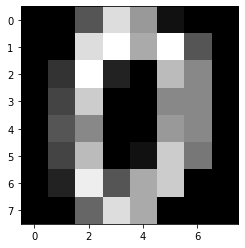

In [8]:
plt.imshow(digits.images[0], cmap=plt.cm.gray)

In [9]:
train_x, test_x, train_y, test_y = train_test_split(data, digits.target, test_size=0.25, random_state=2020)

In [10]:
train_x.max()

16.0

In [13]:
(train_x>1).sum()  # for some pixes

41002

In [14]:
train_x.shape

(1347, 64)

***使用Z-Score规范化***

- 适用范围：z-score适用于属性的最大值和最小值未知的情况，或有超出取值范围的离群数据的情况。
$$z_{ij}=\frac{x_{ij}-x_i}{s_i}$$
其中$x_i$为算术平均值，$s_i$为标准差。

In [15]:
ss = preprocessing.StandardScaler()

In [16]:
train_ss_x = ss.fit_transform(train_x)
test_ss_x = ss.transform(test_x)

## LogisticRegression

***Logistic function***

$$g(z)=\frac{1}{1+e^{-z}}$$
$$g^{\prime}(z) = \frac{d}{dz}\frac{1}{1+e^{-z}}=\frac{1}{(1+e^{-z})^2}(e^{-z}) = \frac{1}{(1+e^{-z})}(1-\frac{1}{1+e^{-z}})=g(z)(1-g(z))$$

In [20]:
import math
def func_logistic(z):
    return 1./ (1 + math.exp(-z))

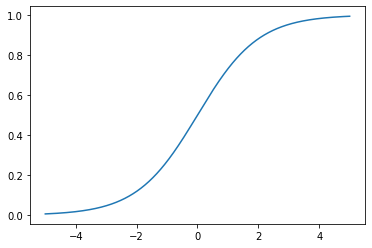

In [21]:
import numpy as np
z = np.linspace(-5, 5, 1000)
g_z = [func_logistic(i) for i in z]
plt.plot(z, g_z)

***LogisticRegression***表达式

逻辑回归的本质是线性回归，只是在特征结果的映射中加入一层函数映射，即先把特征线性求和，然后使用函数$g(z)$将利用假设函数来预测。$g(z)$可以将连续值映射到0到1之间，将线性回归模型的表达式代入$g(z)$，就可以得到*logisticRegression*的表达式：
$$h_{\theta}(x) = g(\theta^T x) = \frac{1}{1 + e^{-\theta^Tx}}$$
按照线性回归模型的表达方式，让$x_0=1$，这样的话，表达式就转换为，
$$\theta^Tx=\theta_0 + \sum_{j=1}^n \theta_j x_j$$

***LogisticRegression***软分类

将$y$的取值$h_{\theta}(x)$通过logistic函数归一化到$(0,1)$之间，它表示取1的概率，因此在这个基础上，对于输入$x$的分类结果为类别1和0的概率分别为：
$$P(y=1|x;\theta)=h_{\theta}(x)$$
$$P(y=0|x;\theta)=1-h_{\theta}(x)$$
对上面的表达式合并一下就是,
$$p(y|x;\theta)=(h_{\theta}(x))^y (1-h_{\theta}(x))^{1-y}$$

**梯度上升**

前提：训练样本相互独立，似然函数表达式为
$$\begin{align} L(\theta)= &p(\bar{y}|X;\theta)\\=&\prod_{i=1}^m p(y^{(i)}; \theta)\\=&\prod_{i=1}^m (h_{\theta}(x^{(i)}))^{y^{(i)}}(1-h_{\theta}(x^{(i)}))^{1-y^{(i)}}\end{align}$$
对似然函数取$log$函数
$$\begin{align}l(\theta) = &logL(\theta) \\=& \sum_{i=1}^m y^{(i)} log h(x^{(i)}) + (1-y^{(i)})log(1-h(x^{(i)}))\end{align}$$
转换后的似然函数对$\theta$求偏导，这里采用一个训练样本进行训练为例
$$\begin{align}\frac{\partial}{\partial \theta_j} l(\theta)=&(y\frac{1}{g(\theta^Tx)} - (1-y)\frac{1}{1-g(\theta^Tx)})\frac{\partial}{\partial \theta_j}g(\theta^Tx)\\=&(y\frac{1}{g(\theta^Tx)} - (1-y)\frac{1}{1-g(\theta^Tx)}) g(\theta^T)(1-g(\theta^Tx)) \frac{\partial}{\partial \theta_j}\theta^T x \\=& (y(1-g(\theta^Tx))-(1-y)g(\theta^Tx))x_j\\=& (y-h_{\theta}(x)) x_j\end{align}$$

由此可以得到梯度上升的迭代更新方向，那么$\theta$的迭代表达式为
$$\theta_j := \theta_j + \alpha (y^{(i)-h_\theta(x^{(i)})}) x_j^{(i)}$$

In [22]:
lr = LogisticRegression(solver='liblinear', multi_class='auto')

***solver***
- liblinear:使用开源库liblinear库实现，内部使用了坐标轴下降法来迭代优化损失函数
- lbfgs: 拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数
- newton-cg: 牛顿家族的一种
- sag: 随机平均梯度下降，梯度下降的变种，随机梯度下降是每次仅用一部分的样本来计算梯度

In [23]:
lr.fit(train_ss_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
predict_y = lr.predict(test_ss_x)

In [25]:
print('Accuracy of LR', accuracy_score(predict_y, test_y))

Accuracy of LR 0.9755555555555555


## CART

In [27]:
model = DecisionTreeClassifier()

In [28]:
model.fit(train_ss_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [29]:
predict_y = model.predict(test_ss_x)

In [30]:
print('Accuracy of CART', accuracy_score(predict_y, test_y))

Accuracy of CART 0.8711111111111111


## LDA

In [31]:
model = LinearDiscriminantAnalysis(n_components=2)

In [32]:
model.fit(train_ss_x, train_y)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [33]:
predict_y = model.predict(test_ss_x)

In [34]:
print('Accuracy of LDA', accuracy_score(predict_y, test_y))

Accuracy of LDA 0.9644444444444444


## Naive Bayesian

In [39]:
model = GaussianNB()

In [40]:
model.fit(train_x, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [41]:
predict_y = model.predict(test_x)

In [42]:
print('Accuracy of NB', accuracy_score(predict_y, test_y))

Accuracy of NB 0.8355555555555556


## SVM

In [43]:
model = svm.SVC(kernel='rbf', C=1.0, gamma='auto')
model.fit(train_ss_x, train_y)
predict_y = model.predict(test_ss_x)
print('Accuracy of SVM', accuracy_score(predict_y, test_y))

Accuracy of SVM 0.9866666666666667


## AdaBoost

In [45]:
dt_stump = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)
dt_stump.fit(train_ss_x, train_y)
n_estimators = 500
model = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=n_estimators)
model.fit(train_ss_x, train_y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [46]:
predict_y = model.predict(test_ss_x)

In [47]:
print('Accuracy of Adaboost', accuracy_score(predict_y, test_y))

Accuracy of Adaboost 0.9666666666666667


## XGBoost

In [48]:
model = XGBClassifier()
model.fit(train_ss_x, train_y)
predict_y = model.predict(test_ss_x)
print('Accuracy of XGBoost', accuracy_score(predict_y, test_y))

Accuracy of XGBoost 0.9622222222222222
